In [61]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr

import subprocess
from datetime import datetime
import matplotlib.ticker as ticker


/tmp/ipykernel_1896090/3203985270.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [62]:
# df.to_csv(os.path.join(outdir, "cartpole_DQN_Adam_AdamPlus_betas_2025_04_10.csv"))
# df.to_csv(os.path.join(outdir, "cartpole_VanillaDQN_Adam_AdamPlus_betas_2025_04_10_corrected.csv"))
# df.to_csv(os.path.join(outdir, "{}_VanillaDQN_Adam_AdamPlus_betas_2025_04_12_lr_decay_0.93_100.csv".format(games[0])))

In [75]:
output_dir = "output"
envs = ["mnist"]
csvfiles = os.listdir(output_dir)
optimizers = ["AdamPlus", "Adam", "AMSGradPlus", "AMSGrad", "AdamWPlus", "AdamW", "Adam2", "Adopt", "Lamb", "LambPlus"] 
# optimizers = ["AdamW", "AdamWPlus"]
# optimizers = ["AMSGrad", "AMSGradPlus"]
optimizers_low = [x.lower() for x in optimizers]
weight_decays = ["0.0", "1.0e-05", "1.0e-04", "1.0e-03", "1.0e-02"]
lrs = ["1.0e-04", "5.0e-04", "1.0e-03"]
df = pd.DataFrame([])
for csvfile in sorted(csvfiles):
    fullpath = os.path.join(output_dir, csvfile)
    if fullpath[-4:] != ".csv":
        continue
    cfgs = csvfile[0:-4].split("_")
    if len(cfgs) < 7:
        continue
    env, optimizer, learning_rate, beta2, seed, dr, ds = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6]
    batchsize = cfgs[7]
    wd = "0.0"
    if len(cfgs) >= 9:
        wd = cfgs[8]
        if wd not in weight_decays:
            continue
    if optimizer.lower() not in optimizers_low:
        continue
    if env not in envs:
        continue
    if seed[4:] not in ["51"]:
        continue
    if learning_rate not in lrs:
        continue
    if dr not in ["1.0"]:
        continue
    if batchsize not in ["100"]:
        continue
    # if learning_rate not in ["1.0e-04"]:
    #     continue
    # if optimizer == "AMSGradPlus" and (learning_rate != "1.0e-04"):
    #     continue
    # if optimizer == "Adam2" and (learning_rate != "1.0e-04"):
    #     continue
    # print(csvfile)
    df_tmp = pd.read_csv(fullpath, index_col=0)
    df_tmp["env"] = env
    df_tmp["opt"] = optimizer
    df_tmp["beta2"] = beta2
    df_tmp["learning_rate"] = learning_rate
    df_tmp["weight_decay"] = wd
    df_tmp["mini_batch"] = (df_tmp["epoch"]-1)*df_tmp['mini-batch'].max() + df_tmp["mini-batch"]
    df_tmp["file"]=csvfile[0:-4]
    df_tmp["step"] = df_tmp["mini_batch"]/df_tmp['mini-batch'].max()
    df = pd.concat([df, df_tmp], ignore_index=False)

df = df.reset_index(drop=True)
# new_df = df.groupby(["epoch", "opt", "beta2", "file"]).last().reset_index()
# new_df
print(df.groupby(["opt","beta2"])[["runtime"]].median())
print(df.groupby(["opt","beta2"])[["epoch","mini_batch","acc_tr","acc_val"]].max())
# print(df.groupby(["opt","beta2"])[["loss_tr","loss_val"]].min())

                    runtime
opt         beta2          
ADOPT       0.5    1.879893
            0.9    2.532823
            0.999  1.693712
AMSGrad     0.999  1.694753
AMSGradPlus 0.999  1.892184
Adam        0.5    1.667132
            0.9    1.679416
            0.999  1.676401
Adam2       0.5    1.636340
            0.9    1.782768
            0.999  1.919733
AdamPlus    0.5    1.859936
            0.9    1.841949
            0.999  1.865595
AdamW       0.5    1.712942
            0.9    1.681870
            0.999  1.671053
AdamWPlus   0.5    1.775749
            0.9    1.848513
            0.999  1.871238
Lamb        0.5    1.822284
            0.9    1.825970
            0.999  1.811778
LambPlus    0.5    1.950992
            0.9    1.944167
            0.999  1.966193
                   epoch  mini_batch  acc_tr  acc_val
opt         beta2                                    
ADOPT       0.5        1         200  0.8437   0.8811
            0.9        1         200  0.8288   0.8687


In [76]:
df['opt'] = df['opt'].str.replace('Lamb', 'LAMB', regex=False)

./output/fig/MNIST_image_classification_fixed_lr_group1_loss_tr.pdf
./output/fig/MNIST_image_classification_fixed_lr_group1_loss_val.pdf
./output/fig/MNIST_image_classification_fixed_lr_group1_acc_tr.pdf
./output/fig/MNIST_image_classification_fixed_lr_group1_acc_val.pdf


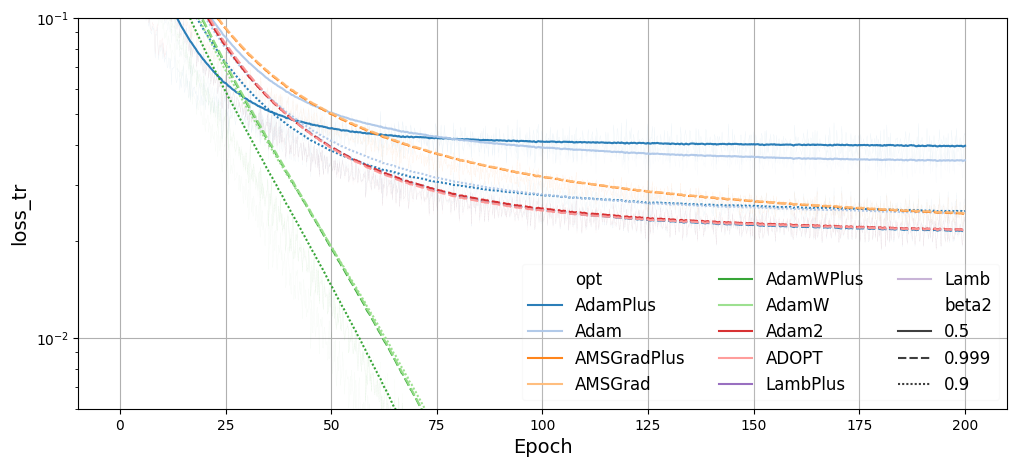

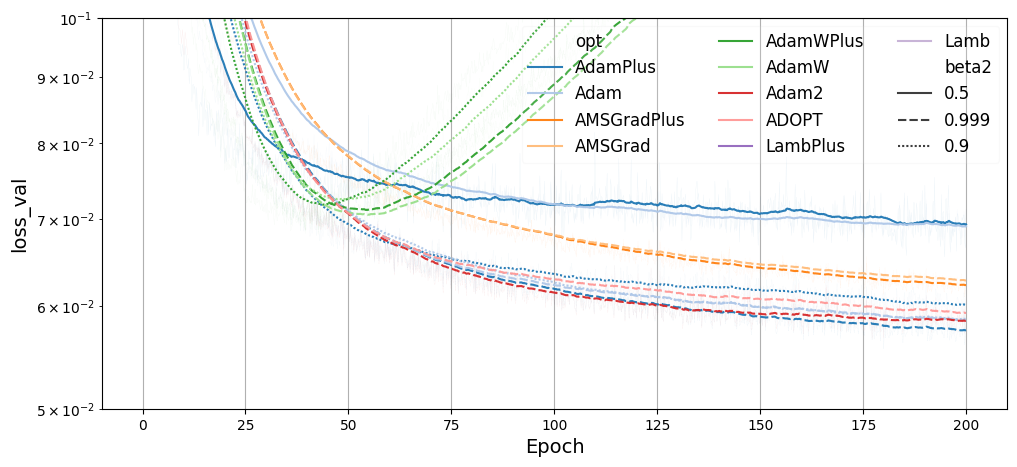

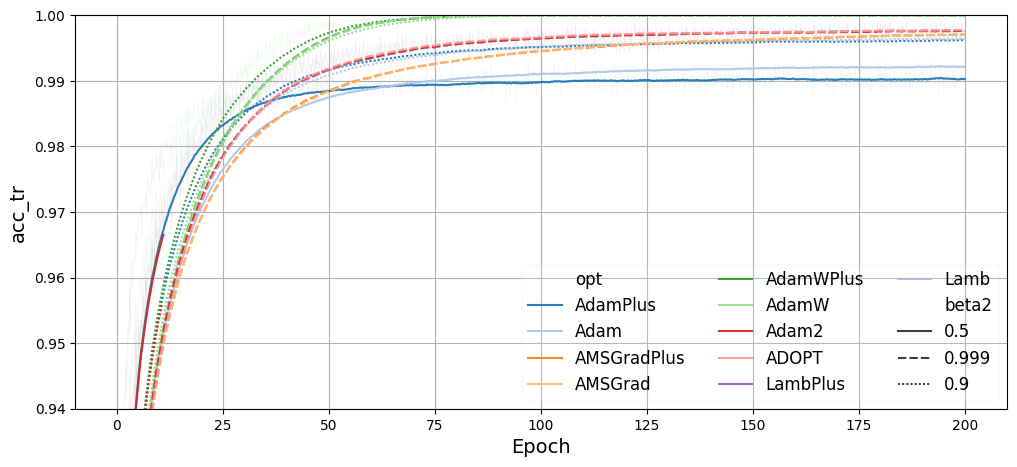

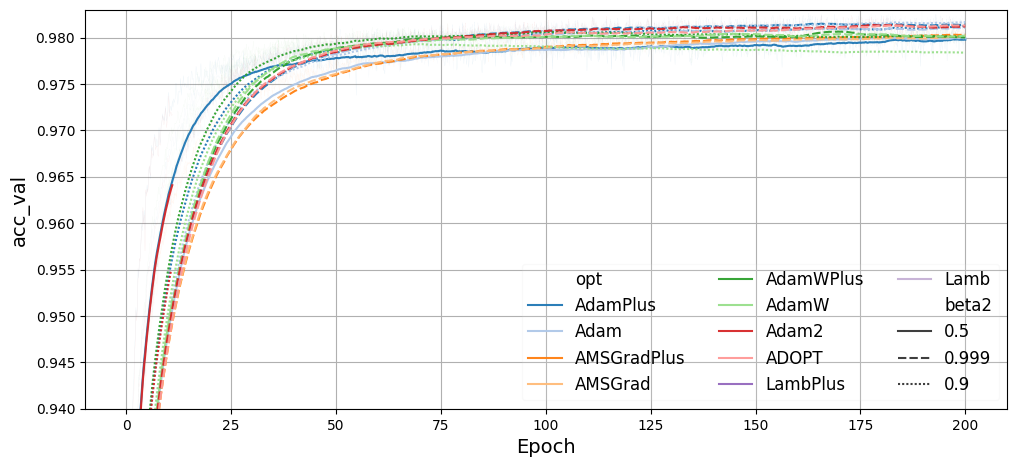

In [78]:
item = "score"
task = "MNIST_image_classification_fixed_lr_group1"

df_tmp = df
# df_tmp= df_tmp[df_tmp["learning_rate"]=="5.0e-04"]
# df_tmp= df_tmp[df_tmp["opt"]=="AMSGradPlus"]
palette = sns.color_palette("tab20", n_colors=df_tmp["opt"].nunique())
for item in ["loss_tr", "loss_val", "acc_tr", "acc_val"]: 
    fname = './output/fig/{}_{}.pdf'.format(task, item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))

    alpha = 0.025  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["opt", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        # x="epoch", 
        x="step", 
        y=item, 
        hue="opt",
        hue_order=["AdamPlus", "Adam", 
                   "AMSGradPlus", "AMSGrad",
                    "AdamWPlus", "AdamW", 
                   "Adam2", "ADOPT",
                    "LambPlus", "Lamb"
                    # "Adam4",  "Adam41", "Adam42", "Lamb4", "Lion", "AdaBelief", # "AdaGrad", "AdaBound"
                    ],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        style="beta2",
        # style_order=["0.999","0.5","0.99","0.9"],
        palette=palette, 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        alpha=0.1,
        linewidth=0.2,
        ax=ax,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="step",
        y=ema_col,
        hue="opt",
        hue_order=["AdamPlus", "Adam", 
                   "AMSGradPlus", "AMSGrad", 
                   "AdamWPlus", "AdamW", 
                   "Adam2", "ADOPT", 
                   "LambPlus", "Lamb",
                   # "Adam4",  "Adam41", "Adam42", "Lamb4", "Lion", "AdaBelief", # "AdaGrad", "AdaBound"
                    ],

        style="beta2",
        # style_order=["0.999"],
        # style_order=["0.999", "0.5", "0.9", "0.99"],
        # hue_order=optimizers,
        # hue_order=["Adam", "AdamPlus", "Adam2", "Adam4","Adam42", "Lamb", "LambPlus", "Lamb4", "AMSGrad", "Lion", "Adopt", "AdaBelief"],
        # hue_order=["LambPlus"],
        palette=palette,
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.95,
        # legend=False,  # avoid duplicate legend entries
    )    
        
    
    L = ax.legend(
        fontsize=12,
        framealpha=0.1,
        ncol=3,
        # loc='upper right',
    #     loc='lower right',
    )

    if item in ["loss_tr", "loss_val"]:
        plt.yscale("log")
        if item == "loss_tr":
            ax.set_ylim([0.006,0.1])
        elif item == "loss_val":
            ax.set_ylim([0.05,0.1])
    elif item == "acc_tr":
        ax.set_ylim([0.94, 1.0])
    elif item == "acc_val":
        ax.set_ylim([0.94, 0.983])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 180000])
    # ax.set_xlim([1, 100])
    ax.grid(True)
    # ax.set_xlabel('Mini-batch', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    # plt.xscale("log")
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    # fig.savefig(fname,
    #             dpi=300,  # facecolor='w', edgecolor='w',
    #             orientation='portrait',
    #             format='pdf')


In [79]:
optimizer_pairs = {
    'AMSGrad': 'AMSGrad+',
    'Adam': 'Adam+',
    'ADOPT': 'ADOPT+',
    'LAMB': 'LAMB+',
    'AdamW': 'AdamW+'
}

In [80]:
df_tmp['opt'] = df_tmp['opt'].str.replace('AMSGradPlus', 'AMSGrad+', regex=False)
df_tmp['opt'] = df_tmp['opt'].str.replace('AdamPlus', 'Adam+', regex=False)
df_tmp['opt'] = df_tmp['opt'].str.replace('Adam2', 'ADOPT+', regex=False)
df_tmp['opt'] = df_tmp['opt'].str.replace('LAMBPlus', 'LAMB+', regex=False)
df_tmp['opt'] = df_tmp['opt'].str.replace('AdamWPlus', 'AdamW+', regex=False)


In [81]:
df = df_tmp
merged = pd.DataFrame()
for base, plus in optimizer_pairs.items():
    merge_keys = ['epoch', 'mini-batch', 'step', 'beta2', 'learning_rate', 'weight_decay']

    df_base = df[df['opt'] == base]
    df_plus = df[df['opt'] == plus]

    df_merged = pd.merge(
        df_plus, df_base,
        on=merge_keys,
        suffixes=('_plus', '_base')
    )
    df_merged['loss_tr_ema_diff'] = df_merged['loss_tr_ema_plus'] - df_merged['loss_tr_ema_base']
    df_merged['loss_val_ema_diff'] = df_merged['loss_val_ema_plus'] - df_merged['loss_val_ema_base']
    df_merged['acc_tr_ema_diff'] = df_merged['acc_tr_ema_plus'] - df_merged['acc_tr_ema_base']
    df_merged['acc_val_ema_diff'] = df_merged['acc_val_ema_plus'] - df_merged['acc_val_ema_base']
    merged = pd.concat([merged, df_merged], axis=0)

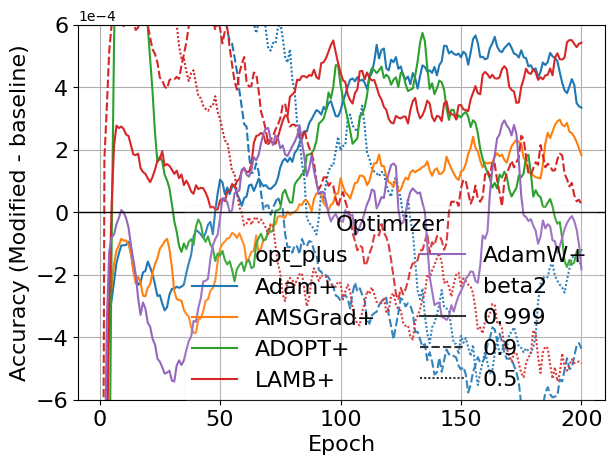

In [ ]:
# merged = merged[merged['beta2'] == '0.999']
for item in ["acc_val_ema_diff"]:
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))
    fname = './output/fig/MNIST_{}.pdf'.format(item)
    sns.lineplot(
            data=merged, 
            x="epoch", 
            y=item, 
            hue="opt_plus",
            hue_order=["Adam+",  "AdamW+" "AMSGrad+", "ADOPT+", "LAMB+", 
                    # "AMSGradPlus", "AMSGrad", "AdamWPlus", "AdamW", "Adam2", "Adopt", "LambPlus", "Lamb"
                        # "Adam4",  "Adam41", "Adam42", "Lamb4", "Lion", "AdaBelief", # "AdaGrad", "AdaBound"
                        ],
            # style="agent",
            # style_order=["DQN", "VanillaDQN"],
            style="beta2",
            style_order=["0.999","0.9","0.5"],
            # style_order=["0.999"],
            palette="tab10", 
            errorbar=None,
            # markers=["o", "p", "*"],
            # markersize=14,
            # dashes=False,
            # linestyle="dotted",
            alpha=1,
            linewidth=1.5,
            ax=ax,
            legend=True,  # avoid duplicate legend entries
        )
    # L.set_title("Plus - Base")
    # ax.set_xlim([10, None])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-4, -4))
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=1, linestyle='-')

    if item == 'acc_val_ema_diff':
        ax.set_ylim([-0.0006, 0.0006])
        ax.set_ylabel("Accuracy (Modified - baseline)", fontsize=16)
        plt.subplots_adjust(left=0.12, right=0.999, top=0.965, bottom=0.132)
        loc = (0.2, 0.0)

    elif item == 'loss_val_ema_diff':
        ax.set_ylim([-0.0017, 0.00035])
        ax.set_ylabel("Loss (Modified - baseline)", fontsize=16)
        plt.subplots_adjust(left=0.144, right=0.999, top=0.965, bottom=0.132)
        loc = (0.1, 0.015)
    L = ax.legend(
        title="Optimizer",
        title_fontsize=16,
        fontsize=16,
        framealpha=0.1,
        ncol=2,
        # loc='upper right',
        loc=loc,
    )
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')

In [24]:
res_df = df_tmp.groupby(["opt","beta2"])[["runtime"]].mean()
res_df2 = df_tmp.groupby(["opt","beta2"])[["epoch","mini_batch","acc_tr_ema","acc_val_ema"]].max()
res_df3 = df_tmp.groupby(["opt","beta2"])[["loss_tr_ema","loss_val_ema"]].min()
res_df = pd.concat([res_df, res_df2, res_df3], axis=1)
res_df = res_df.reset_index()
res_df.to_csv(os.path.join(output_dir,"mnist_cnn_result_table.csv"))
res_df

,opt,beta2,runtime,epoch,mini_batch,acc_tr_ema,acc_val_ema,loss_tr_ema,loss_val_ema
0,ADOPT,0.999,1.813617,200,120000,0.997790,0.981339,2.166061e-02,0.059245
1,AMSGrad,0.999,1.810806,200,120000,0.997148,0.980145,2.446191e-02,0.062763
2,AMSGradPlus,0.999,1.978732,200,120000,0.997099,0.980320,2.436373e-02,0.062244
3,Adam,0.5,1.802783,200,120000,0.992220,0.979972,3.564920e-02,0.069053
4,Adam,0.9,1.794477,200,120000,0.996482,0.981680,2.443163e-02,0.058596
5,Adam,0.999,1.802861,200,120000,0.997683,0.981061,2.166600e-02,0.058507
6,Adam2,0.999,2.010566,200,120000,0.997666,0.981368,2.170198e-02,0.058418
7,AdamPlus,0.5,1.954043,200,120000,0.990439,0.979809,3.954040e-02,0.069261
8,AdamPlus,0.9,1.942976,200,120000,0.996214,0.981236,2.474555e-02,0.060081
9,AdamPlus,0.999,1.966007,200,120000,0.997749,0.981498,2.152079e-02,0.057448


In [25]:
# Identify the best (maximum acc_val_ema) beta2 per optimizer
best_combinations = (
    res_df.loc[res_df.groupby("opt")["acc_val_ema"].idxmax()]
)

# Display the selected combinations
best_combinations.sort_values(by=["acc_val_ema"])

,opt,beta2,runtime,epoch,mini_batch,acc_tr_ema,acc_val_ema,loss_tr_ema,loss_val_ema
1,AMSGrad,0.999,1.810806,200,120000,0.997148,0.980145,0.024462,0.062763
2,AMSGradPlus,0.999,1.978732,200,120000,0.997099,0.980320,0.024364,0.062244
11,AdamW,0.999,1.784154,200,120000,0.999999,0.980411,0.000018,0.070494
13,AdamWPlus,0.999,1.970888,200,120000,0.999999,0.980650,0.000012,0.071111
0,ADOPT,0.999,1.813617,200,120000,0.997790,0.981339,0.021661,0.059245
6,Adam2,0.999,2.010566,200,120000,0.997666,0.981368,0.021702,0.058418
9,AdamPlus,0.999,1.966007,200,120000,0.997749,0.981498,0.021521,0.057448
4,Adam,0.9,1.794477,200,120000,0.996482,0.981680,0.024432,0.058596
16,LAMB,0.999,1.923069,200,120000,0.997547,0.982452,0.021503,0.057155
19,LAMBPlus,0.999,2.045479,200,120000,0.997604,0.982839,0.021510,0.056512


In [26]:
show_combs = best_combinations[best_combinations.index.isin([7, 9, 32, 34, 4, 0, 2, 36, 29, 3, 28, 19])]

In [27]:
# Filter df_tmp using the selected best (opt, beta2) combinations
df_filtered = df_tmp.merge(show_combs[["opt", "beta2"]])
df_filtered

,epoch,mini-batch,loss_tr,loss_val,acc_tr,acc_val,SNR,EmaSNR,AdamPlusSNR,m,...,beta2,learning_rate,weight_decay,mini_batch,file,step,loss_tr_ema,loss_val_ema,acc_tr_ema,acc_val_ema
0,1,100,1.579909,0.825645,0.6015,0.8334,NaN,NaN,NaN,NaN,...,0.999,1.0e-04,1.0e-03,100,mnist_ADOPT_1.0e-04_0.999_seed51_1.0_1_100_1.0...,0.166667,1.579909,0.825645,0.601500,0.833400
1,1,200,0.645201,0.492120,0.8479,0.8826,NaN,NaN,NaN,NaN,...,0.999,1.0e-04,1.0e-03,200,mnist_ADOPT_1.0e-04_0.999_seed51_1.0_1_100_1.0...,0.333333,1.106639,0.656772,0.726259,0.858311
2,1,300,0.463882,0.405538,0.8841,0.8974,NaN,NaN,NaN,NaN,...,0.999,1.0e-04,1.0e-03,300,mnist_ADOPT_1.0e-04_0.999_seed51_1.0_1_100_1.0...,0.500000,0.886940,0.570898,0.780211,0.871672
3,1,400,0.385833,0.361525,0.8986,0.9033,NaN,NaN,NaN,NaN,...,0.999,1.0e-04,1.0e-03,400,mnist_ADOPT_1.0e-04_0.999_seed51_1.0_1_100_1.0...,0.666667,0.756866,0.516550,0.810941,0.879882
4,1,500,0.359304,0.336665,0.9021,0.9110,NaN,NaN,NaN,NaN,...,0.999,1.0e-04,1.0e-03,500,mnist_ADOPT_1.0e-04_0.999_seed51_1.0_1_100_1.0...,0.833333,0.673278,0.478729,0.830108,0.886425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,200,200,0.019220,0.057374,0.9985,0.9820,NaN,NaN,NaN,NaN,...,0.999,1.0e-03,1.0e-03,119600,mnist_LambPlus_1.0e-03_0.999_seed51_1.0_1_100_...,199.333333,0.021540,0.056534,0.997596,0.982782
5996,200,300,0.020333,0.057308,0.9979,0.9825,NaN,NaN,NaN,NaN,...,0.999,1.0e-03,1.0e-03,119700,mnist_LambPlus_1.0e-03_0.999_seed51_1.0_1_100_...,199.500000,0.021510,0.056553,0.997604,0.982775
5997,200,400,0.022897,0.055229,0.9968,0.9835,NaN,NaN,NaN,NaN,...,0.999,1.0e-03,1.0e-03,119800,mnist_LambPlus_1.0e-03_0.999_seed51_1.0_1_100_...,199.666667,0.021545,0.056520,0.997584,0.982793
5998,200,500,0.023161,0.056318,0.9967,0.9834,NaN,NaN,NaN,NaN,...,0.999,1.0e-03,1.0e-03,119900,mnist_LambPlus_1.0e-03_0.999_seed51_1.0_1_100_...,199.833333,0.021585,0.056515,0.997562,0.982808


../fig/MNIST_image_classification_fixed_lr_group2_loss_tr.pdf
../fig/MNIST_image_classification_fixed_lr_group2_loss_val.pdf
../fig/MNIST_image_classification_fixed_lr_group2_acc_tr.pdf
../fig/MNIST_image_classification_fixed_lr_group2_acc_val.pdf


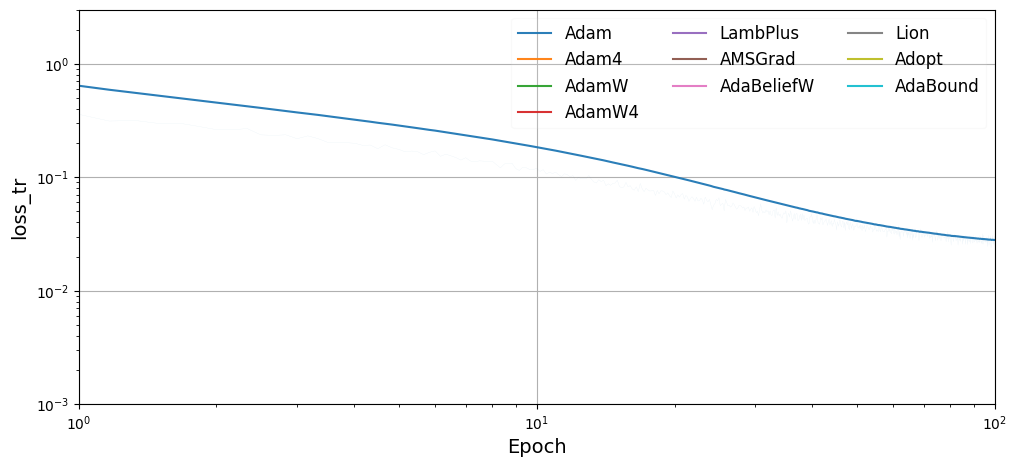

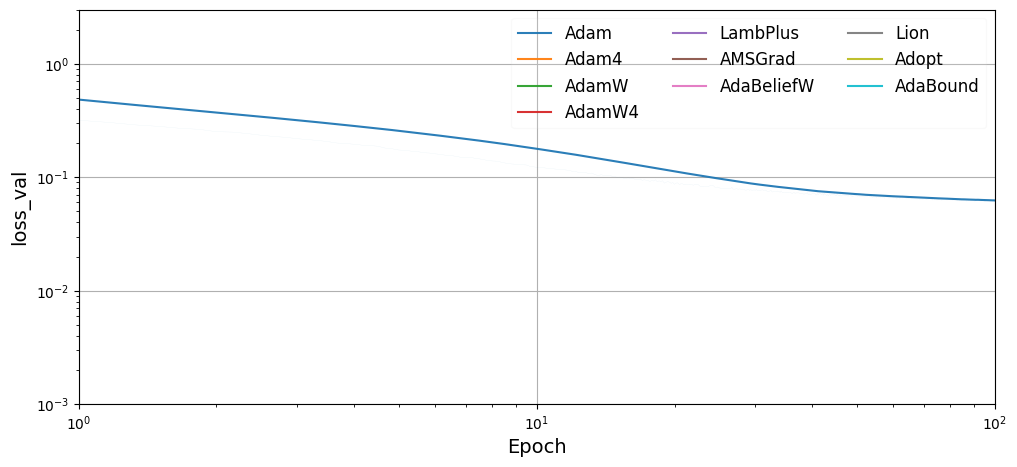

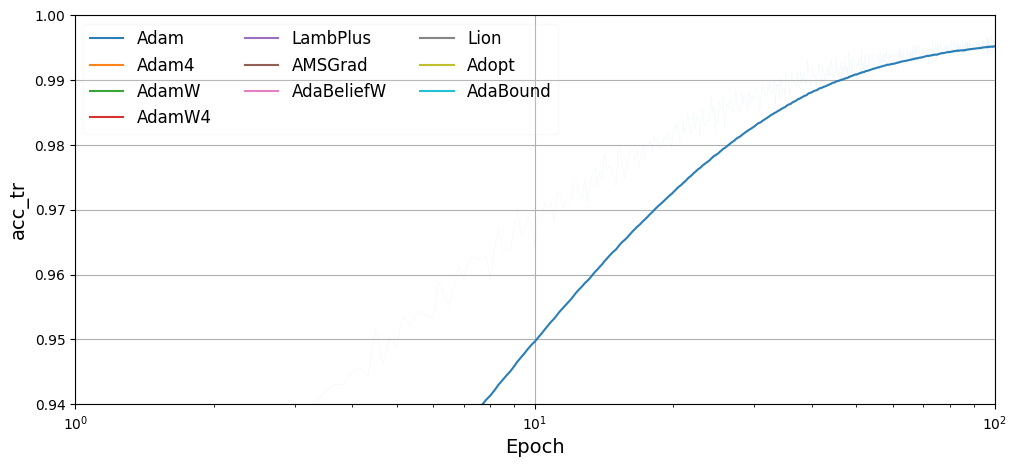

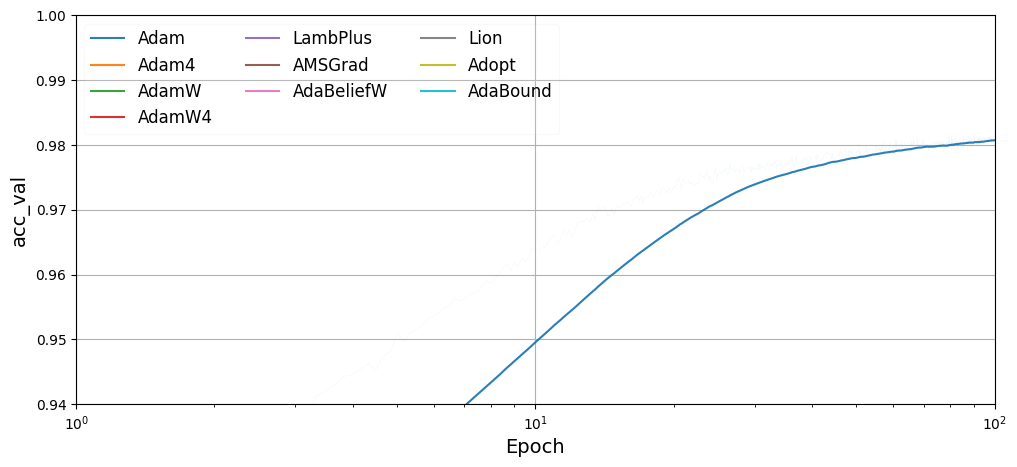

In [28]:
item = "score"
task = "MNIST_image_classification_fixed_lr_group2"
# task = "CIFAR_image_classification_step_lr"

df_tmp = df_filtered
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]=="seed35"]
# df_tmp= df[df["env"]=="lander"]
# for item in ["score", "EmaSNR", "AdamPlusSNR"]: 
for item in ["loss_tr", "loss_val", "acc_tr", "acc_val"]: 
# for item in ["loss_tr", "acc_tr", "acc_val"]: 
    fname = '../fig/{}_{}.pdf'.format(task, item)
    # fname = '../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))

    alpha = 0.025  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["opt", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        # x="epoch", 
        x="step", 
        y=item, 
        hue="opt",
        # hue_order=["Adam", "AdamPlus", "Adam4","Adam42", "AdamW", "AdamW+", "AdamW4", "AdaBeliefW", "Lamb", "LambPlus"],
        hue_order=["Adam", "Adam4", "AdamW", "AdamW4", "LambPlus", "AMSGrad", "AdaBeliefW",  "Lion",  "Adopt", "AdaBound"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        # style="beta2",
        # style_order=["0.999","0.5","0.99","0.9"],
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        alpha=0.1,
        linewidth=0.2,
        ax=ax,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="step",
        y=ema_col,
        hue="opt",
        # style="beta2",
        # style_order=["0.999", "0.5", "0.9", "0.99"],
        hue_order=["Adam", "Adam4", "AdamW", "AdamW4", "LambPlus", "AMSGrad", "AdaBeliefW",  "Lion",  "Adopt", "AdaBound"],
        # hue_order=["Adam", "AdamPlus", "Lamb", "LambPlus", "AMSGrad", "Adam42",  "AdaBelief",  "Lion","Adam2",  "Adopt"],
        # hue_order=["Adam", "AdamPlus", "Adam4","Adam41","Adam42", "Lamb", "LambPlus", "AMSGrad", "AdaBelief",  "Lion",  "Adopt","Adam2", "AdaBound", "AdamW","AdamW+"],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.95,
        # legend=False,  # avoid duplicate legend entries
    )    
        
    
    L = ax.legend(
        fontsize=12,
        framealpha=0.1,
        ncol=3,
        # loc='upper right',
    #     loc='lower right',
    )

    if item in ["loss_tr", "loss_val"]:
        plt.yscale("log")
        ax.set_ylim([0.001,3])
    else:
        ax.set_ylim([0.94, 1.0])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 180000])
    ax.set_xlim([1, 100])
    ax.grid(True)
    # ax.set_xlabel('Mini-batch', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    plt.xscale("log")
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')
